In [1]:
pip install ucimlrepo

In [2]:
pip install xgboost

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")  # default style
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from keras import metrics
from scipy.stats import chi2_contingency
from xgboost import XGBClassifier

In [4]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
X = mushroom.data.features
y = mushroom.data.targets

# metadata
print(mushroom.metadata)

# variable information
print(mushroom.variables)

{'uci_id': 73, 'name': 'Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/73/mushroom', 'data_url': 'https://archive.ics.uci.edu/static/public/73/data.csv', 'abstract': 'From Audobon Society Field Guide; mushrooms described in terms of physical characteristics; classification: poisonous or edible', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 8124, 'num_features': 22, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['poisonous'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1981, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5959T', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': "This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525).  Each species is identified as definitely edible, definitely po

In [5]:
# Quick overview of dataset

# Check shape
print(X.shape)
print(y.shape)

# View first few rows
X.head()

(8124, 22)
(8124, 1)


,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


In [6]:
# Convert 'y' to a 1D Series
y_series = y.squeeze()

# Verify the conversion
print("Shape of y_series after conversion:", y_series.shape)
print("First few values of y_series:", y_series.head())
print("Unique values in y_series:", y_series.unique())


Shape of y_series after conversion: (8124,)
First few values of y_series: 0    p
1    e
2    e
3    p
4    e
Name: poisonous, dtype: object
Unique values in y_series: ['p' 'e']


In [7]:
# Check for missing values
print(X.isnull().sum())

cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64


In [8]:
# Handle missing values in 'stalk-root' by filling with 'missing'
X['stalk-root'] = X['stalk-root'].fillna('missing')

<ipython-input-8-08c48ec9a907>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['stalk-root'] = X['stalk-root'].fillna('missing')


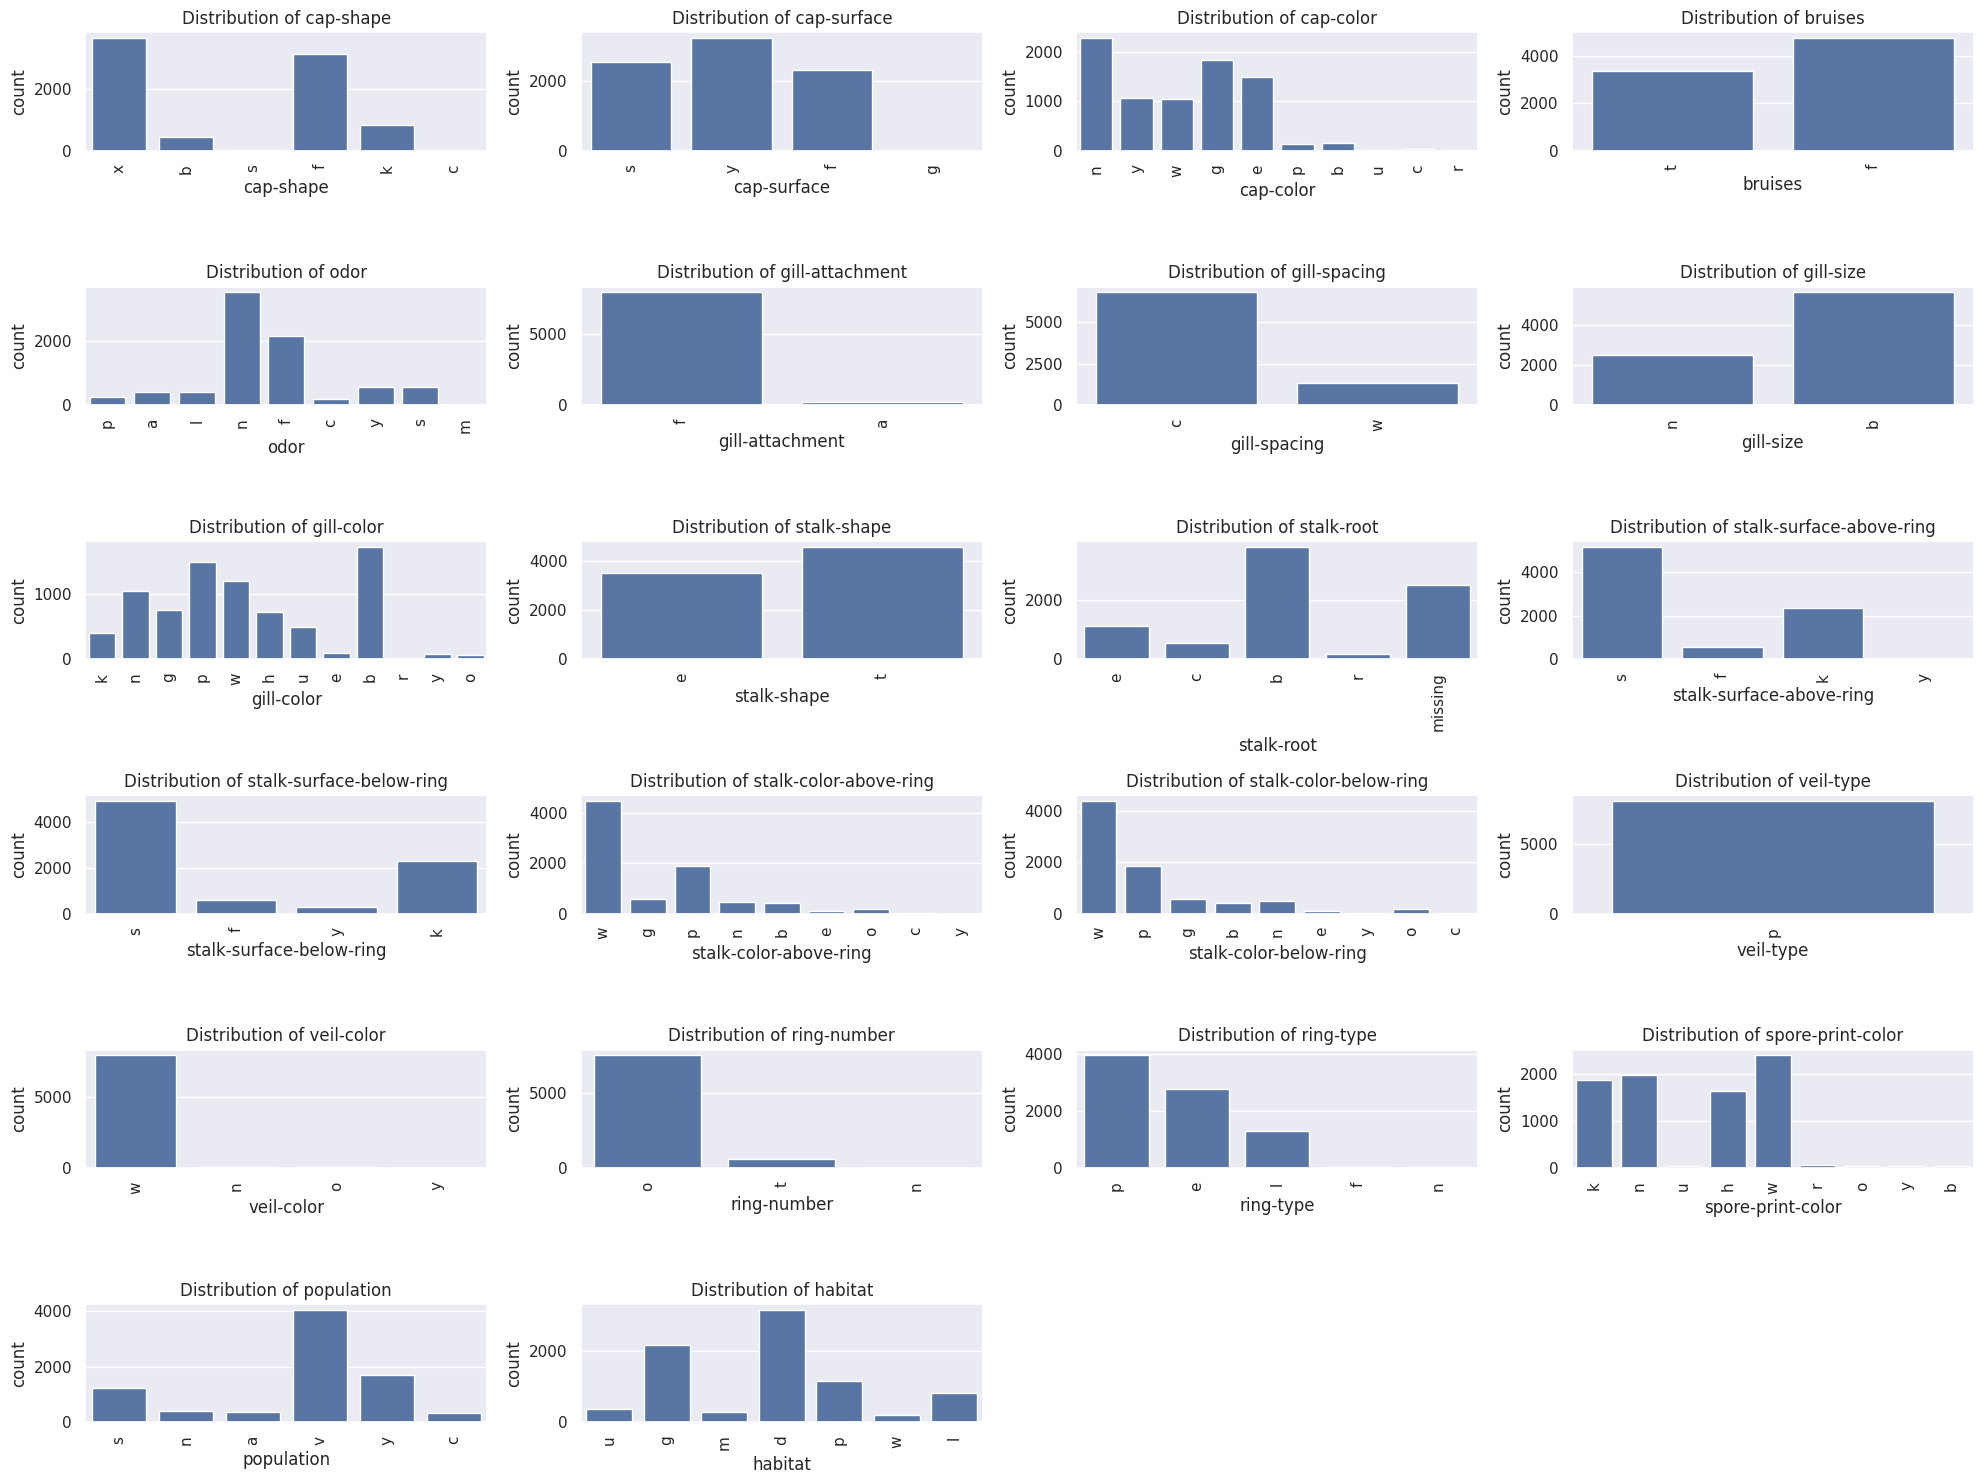

In [9]:
# Number of rows and columns for the grid
n_rows, n_cols = 6, 4

# Create a grid of subplots for feature distributions
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()

# Plot each feature's distribution
for i, column in enumerate(X.columns):
    sns.countplot(data=X, x=column, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].tick_params(axis='x', rotation=90)

# Hide remaining empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

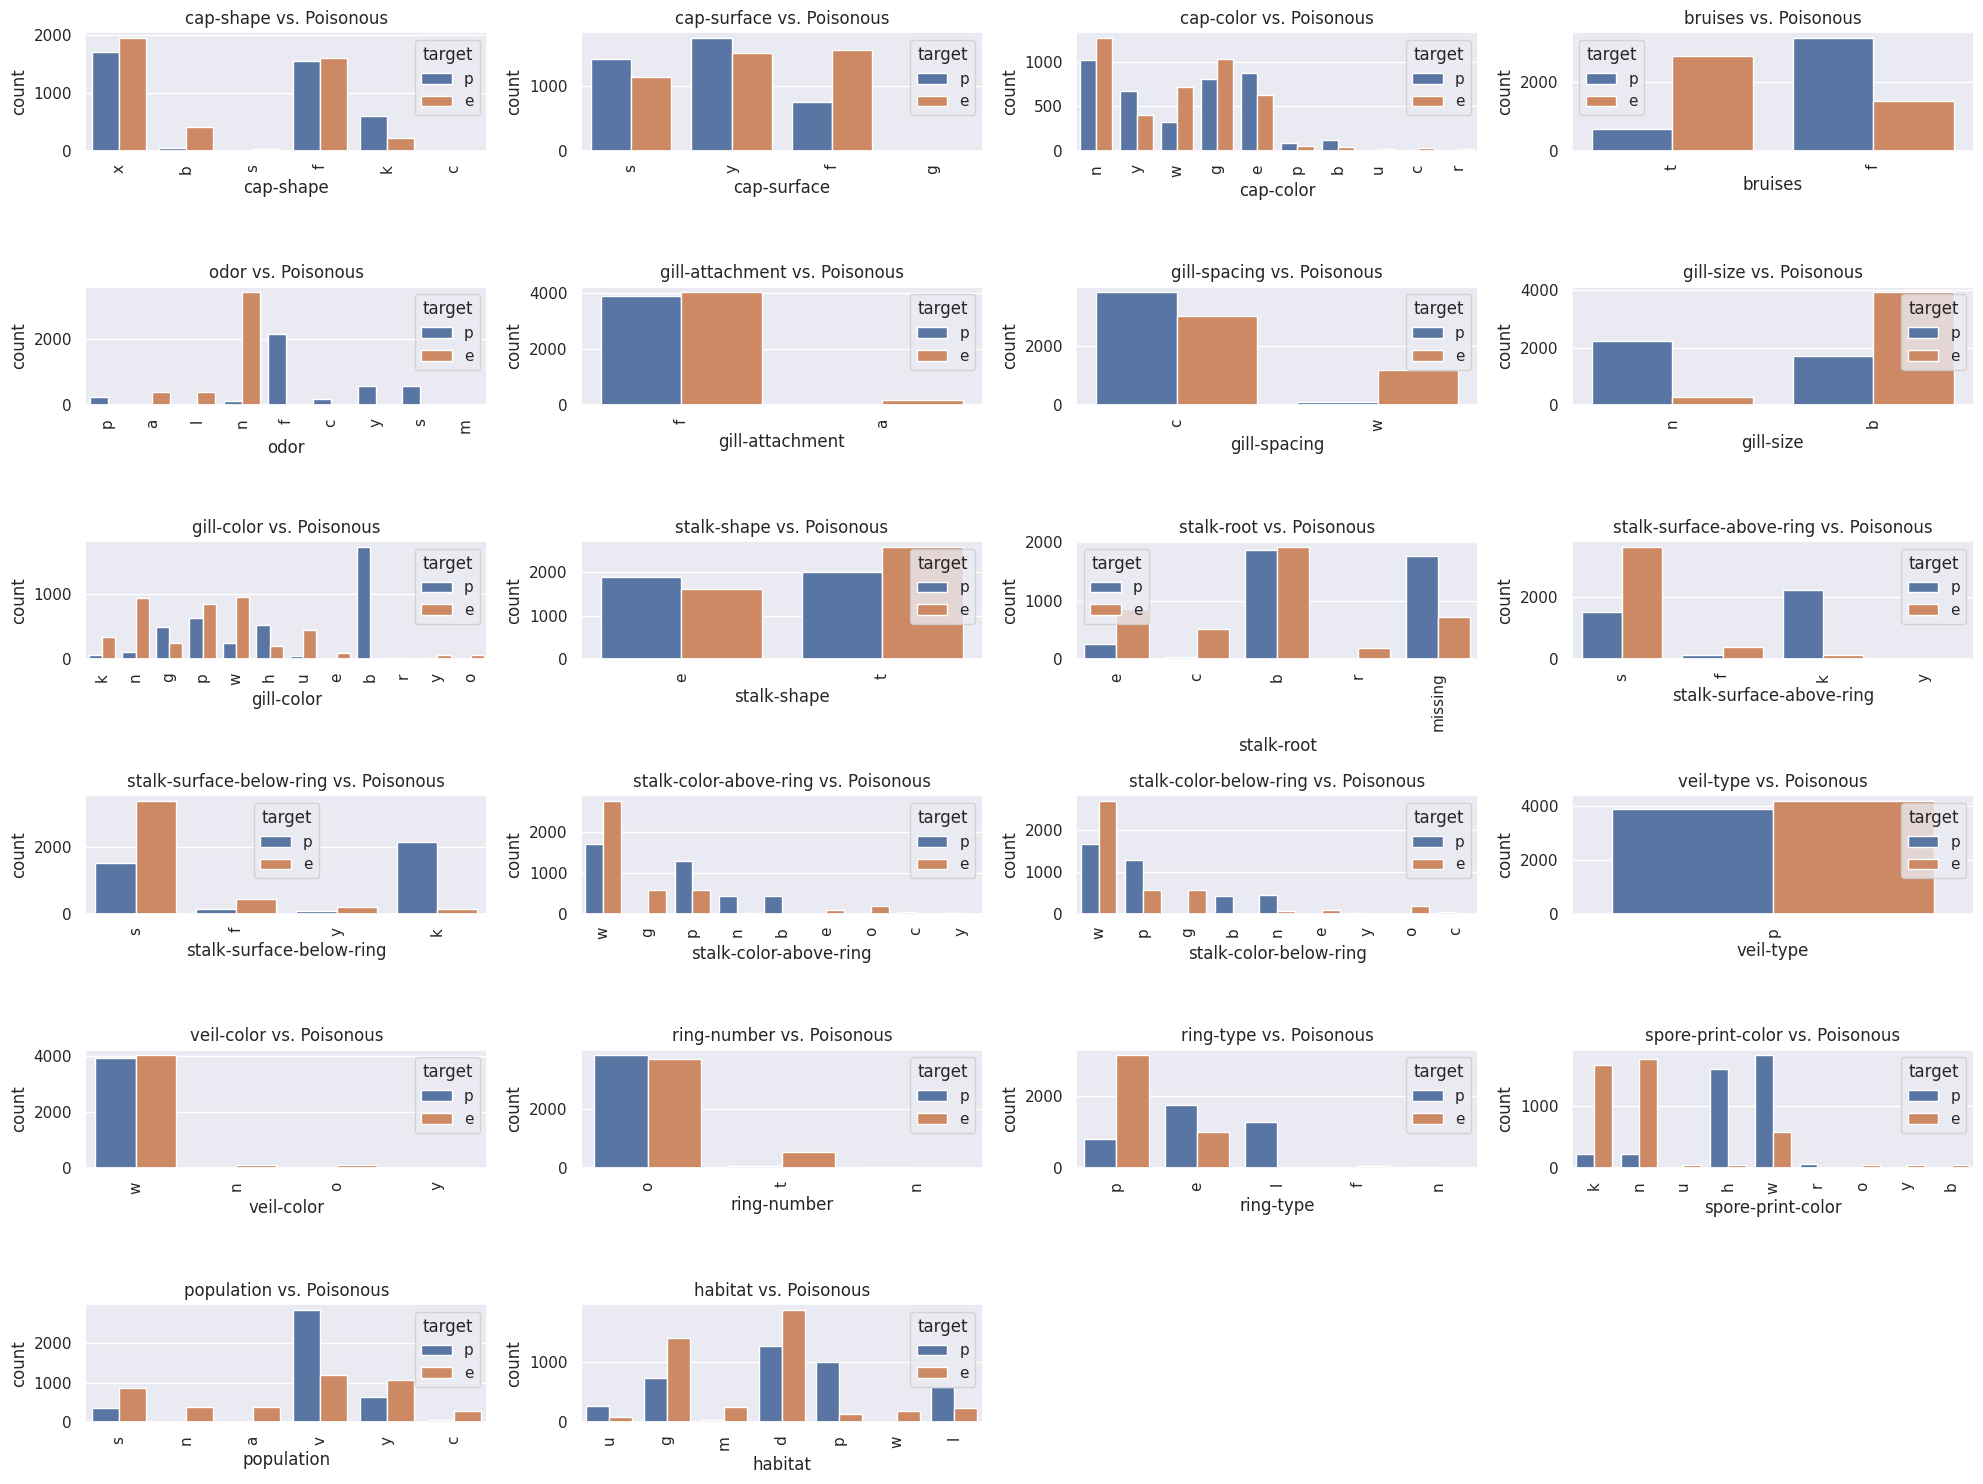

In [10]:
# Add target to the features dataframe temporarily
X['target'] = y_series

# Create a grid of subplots for feature-target relationships
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()

# Plot each feature's relationship with the target
for i, column in enumerate(X.columns[:-1]):  # Exclude the 'target' column itself
    sns.countplot(data=X, x=column, hue='target', ax=axes[i])
    axes[i].set_title(f'{column} vs. Poisonous')
    axes[i].tick_params(axis='x', rotation=90)

# Hide remaining empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Remove the target column after plotting
X = X.drop(columns=['target'])

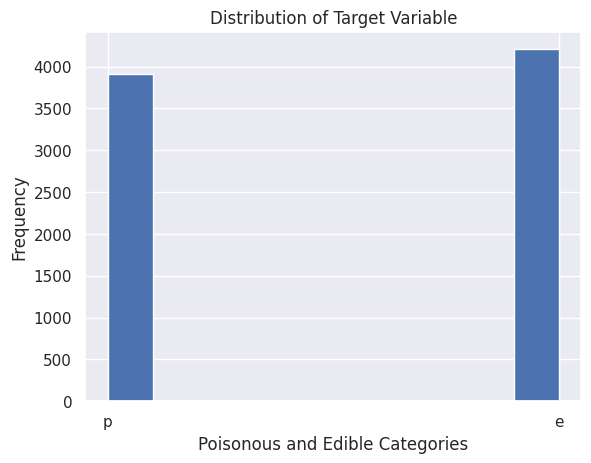

In [11]:
# plot target variable

# Create a grid of subplots for feature distributions
plt.hist(y_series)
plt.title("Distribution of Target Variable")
plt.xlabel("Poisonous and Edible Categories")
plt.ylabel("Frequency")
plt.show()

In [12]:
# Chi-Square analysis for each feature against the target
chi2_results = {}
for column in X.columns:
    contingency_table = pd.crosstab(X[column], y_series)
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    chi2_results[column] = p

# Display results
for feature, p_value in chi2_results.items():
    print(f"{feature}: p-value = {p_value:.4f}")

cap-shape: p-value = 0.0000
cap-surface: p-value = 0.0000
cap-color: p-value = 0.0000
bruises: p-value = 0.0000
odor: p-value = 0.0000
gill-attachment: p-value = 0.0000
gill-spacing: p-value = 0.0000
gill-size: p-value = 0.0000
gill-color: p-value = 0.0000
stalk-shape: p-value = 0.0000
stalk-root: p-value = 0.0000
stalk-surface-above-ring: p-value = 0.0000
stalk-surface-below-ring: p-value = 0.0000
stalk-color-above-ring: p-value = 0.0000
stalk-color-below-ring: p-value = 0.0000
veil-type: p-value = 1.0000
veil-color: p-value = 0.0000
ring-number: p-value = 0.0000
ring-type: p-value = 0.0000
spore-print-color: p-value = 0.0000
population: p-value = 0.0000
habitat: p-value = 0.0000


In [13]:
# One-Hot Encoding of categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Encode the target variable (assuming 'p' = poisonous, 'e' = edible)
y_encoded = y_series.apply(lambda x: 1 if x == 'p' else 0)

In [14]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)


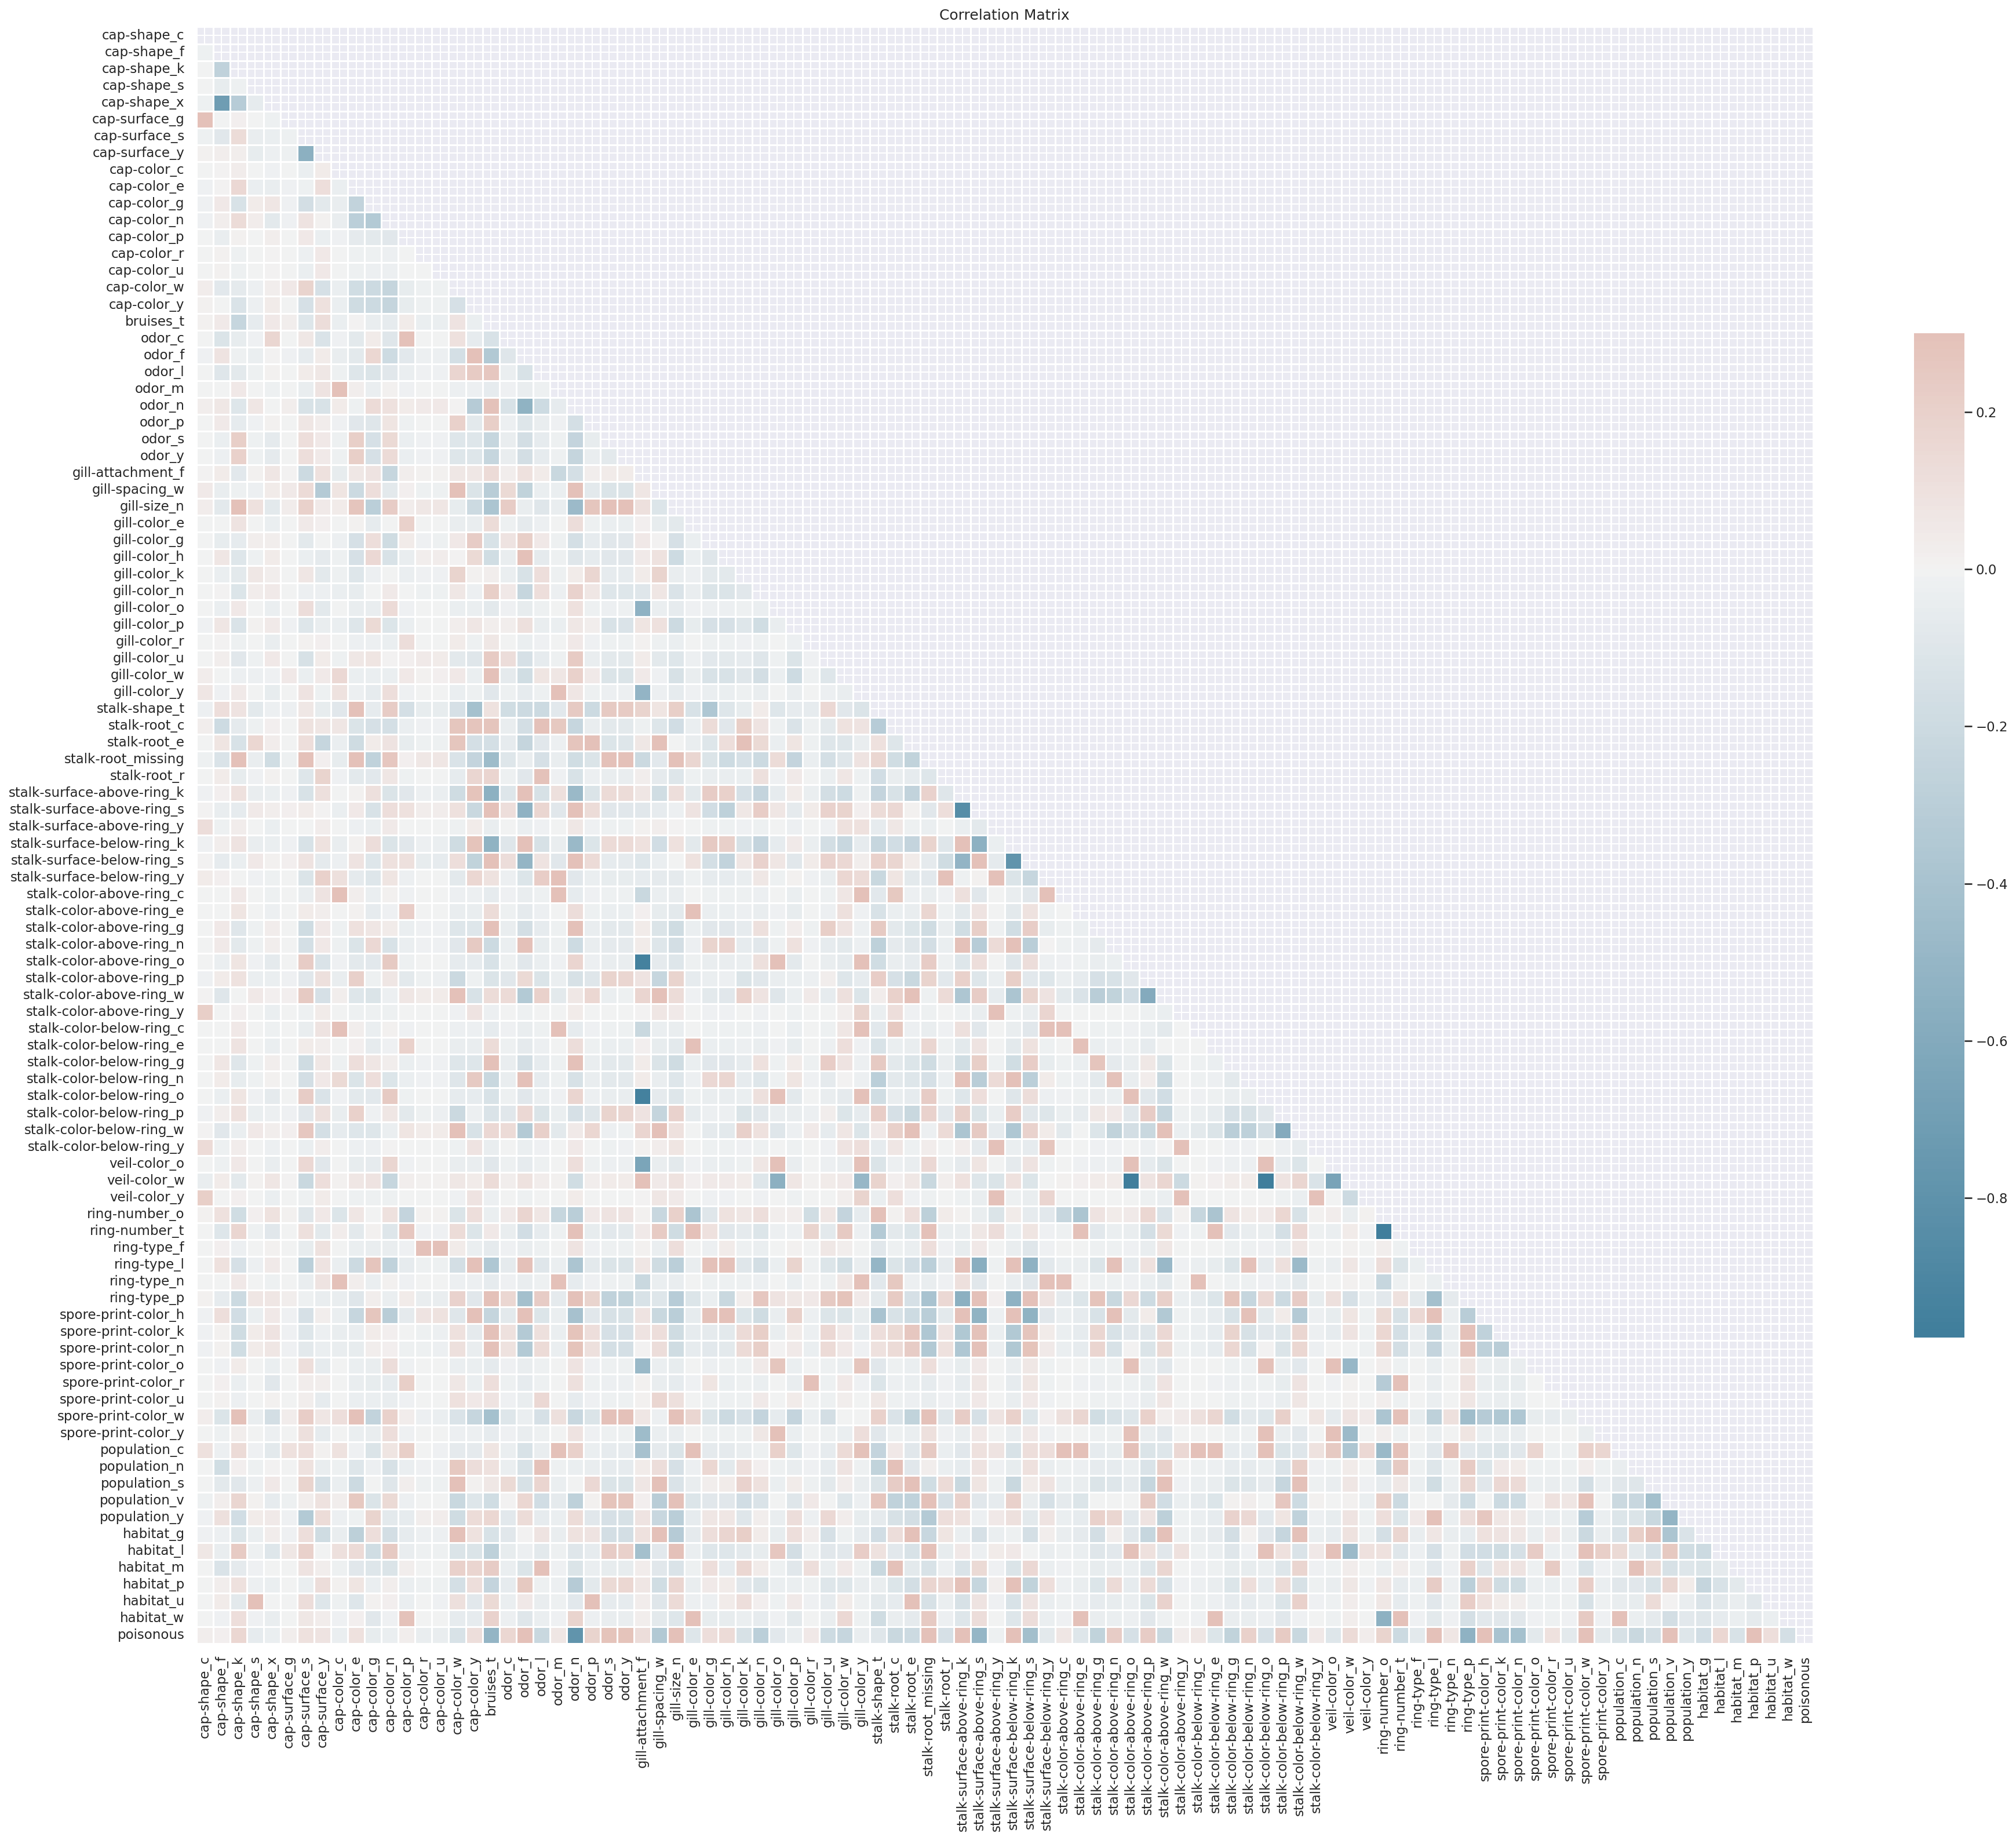

In [15]:
corr = pd.concat([X_train, y_train], axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(30, 30), dpi=150)
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation Matrix')
plt.show()

Baseline Model - Logistic Regression:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


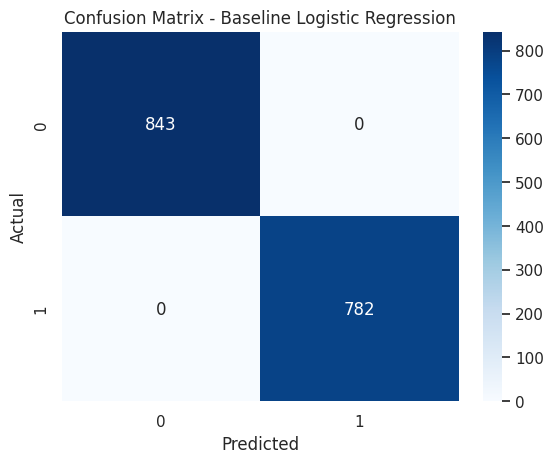

In [16]:
# Initialize and train the Logistic Regression model
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = baseline_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Baseline Model - Logistic Regression:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Baseline Logistic Regression")
plt.show()

Baseline Model - Logistic Regression:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


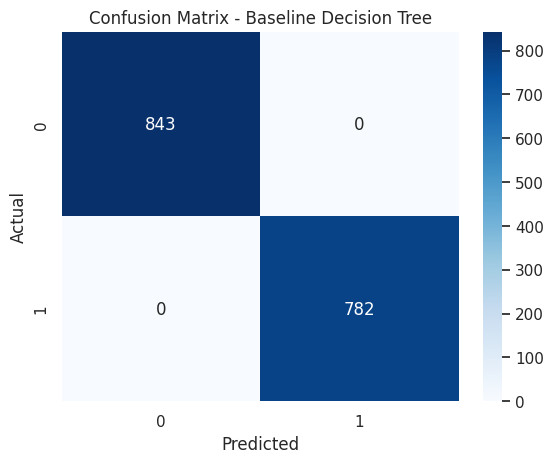

In [17]:
# prompt: generate a decision tree baseline_model_2 which fits X_train and Y_train

from sklearn.tree import DecisionTreeClassifier

# Initialize and train the Decision Tree model
baseline_model_2 = DecisionTreeClassifier(random_state=42)
baseline_model_2.fit(X_train, y_train)

# Make predictions on the test set
y_pred_2 = baseline_model_2.predict(X_test)

# Evaluate the model
accuracy_2 = accuracy_score(y_test, y_pred_2)
precision_2 = precision_score(y_test, y_pred_2)
recall_2 = recall_score(y_test, y_pred_2)
f1_2 = f1_score(y_test, y_pred_2)

print(f"Baseline Model - Logistic Regression:")
print(f"Accuracy: {accuracy_2:.4f}")
print(f"Precision: {precision_2:.4f}")
print(f"Recall: {recall_2:.4f}")
print(f"F1 Score: {f1_2:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Baseline Decision Tree")
plt.show()

In [18]:
# Initialize the XGBoost classifier
xgb_model = XGBClassifier(
    use_label_encoder=False,  # Avoids label encoding warning
    eval_metric='logloss',   # Metric to evaluate during training
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:00:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [19]:
# Make predictions
y_pred_3 = xgb_model.predict(X_test)

In [20]:
# Evaluate the model
accuracy_3 = accuracy_score(y_test, y_pred_3)
precision_3 = precision_score(y_test, y_pred_3)
recall_3 = recall_score(y_test, y_pred_3)
f1_3 = f1_score(y_test, y_pred_3)

print("XGBoost Model Evaluation:")
print(f"Accuracy: {accuracy_3:.4f}")
print(f"Precision: {precision_3:.4f}")
print(f"Recall: {recall_3:.4f}")
print(f"F1 Score: {f1_3:.4f}")


XGBoost Model Evaluation:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


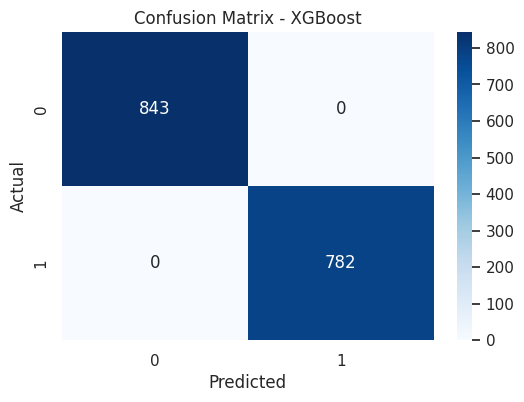

In [21]:
# Confusion Matrix
cm_3 = confusion_matrix(y_test, y_pred_3)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_3, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

In [22]:
# Hyperparameter Tuning

from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    verbose=1
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the tuned model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"Tuned Model Accuracy: {accuracy_tuned:.4f}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:00:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:00:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:00:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:00:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:00:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Tuned Model Accuracy: 1.0000


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:02:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


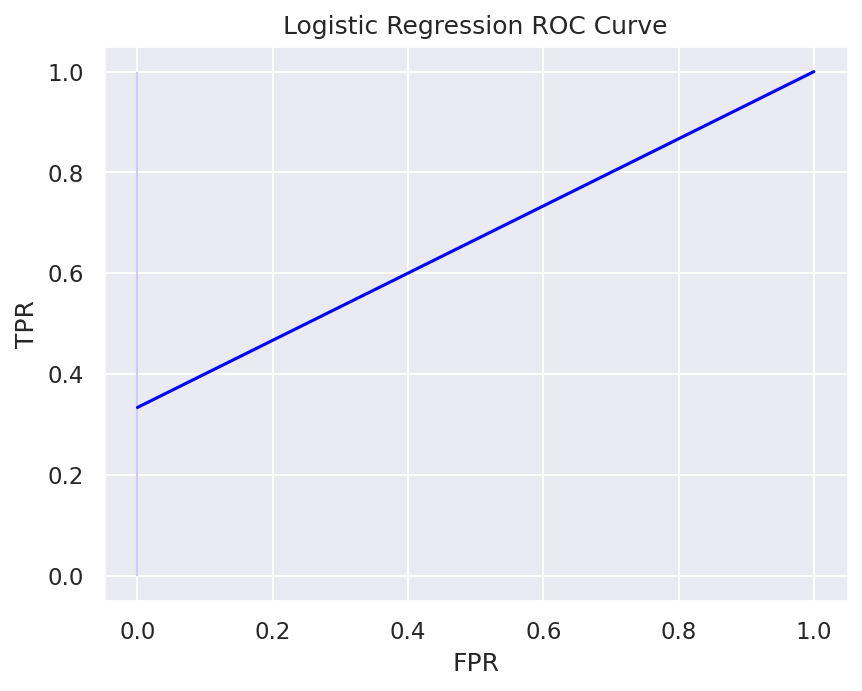

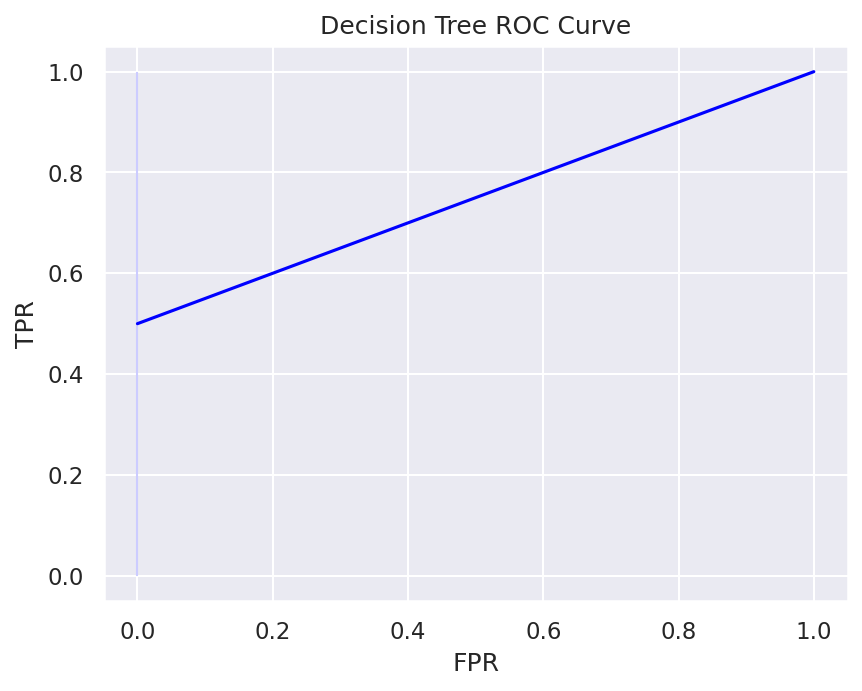

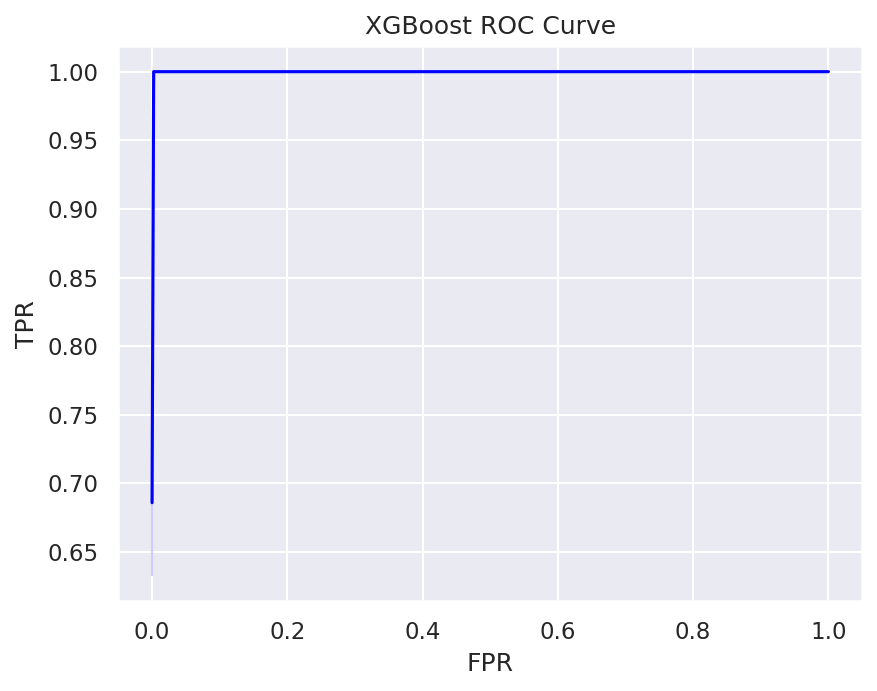

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score

# Logistic Regression ROC Curve
y_prob_lr = baseline_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
auc_lr = roc_auc_score(y_test, y_prob_lr)

# Plot Logistic Regression ROC Curve
fig, ax = plt.subplots(dpi=150)
sns.lineplot(x=fpr_lr, y=tpr_lr, color='blue', ax=ax)
ax.set_title(f'Logistic Regression ROC Curve')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.show()

# Decision Tree ROC Curve
y_prob_dt = baseline_model_2.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
auc_dt = roc_auc_score(y_test, y_prob_dt)

# Plot Decision Tree ROC Curve
fig, ax = plt.subplots(dpi=150)
sns.lineplot(x=fpr_dt, y=tpr_dt, color='blue', ax=ax)
ax.set_title(f'Decision Tree ROC Curve')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.show()

# XGBoost ROC Curve
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

# Plot XGBoost ROC Curve
fig, ax = plt.subplots(dpi=150)
sns.lineplot(x=fpr_xgb, y=tpr_xgb, color='blue', ax=ax)
ax.set_title(f'XGBoost ROC Curve')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.show()
